# Time series econometrics on crypto currency data

## Load data

I'll use Ethereum AUD as an example for now. See https://www.ethereum.org/ for more info.

"Unlike the Bitcoin blockchain which is essentially a list of the transactions on the network, the Ethereum blockchain contains both the list of transactions and the state of the blockchain (in the simplest case, the balances of all the accounts). The Ethereum whitepaper provides a list of potential use cases for the platform, but the primary one is the ability to build ‘smart contracts’ that will execute themselves, eliminating the need for counterparties to rely on each others trustworthiness.
...
There are two major differences between Ether and Bitcoin. First, unlike Bitcoin who’s total supply is capped at 21 million units, there is no fixed supply of Ether. Secondly, blocks are added to the Ether blockchain every 15 seconds (on average), unlike the approximately 10 minutes for Bitcoin." – See [this dude's thesis](https://yorkspace.library.yorku.ca/server/api/core/bitstreams/9be8e8b2-5247-42df-9e7b-eb58f02c633d/content).

In [15]:
#!pip install yfinance
import yfinance as yf
import datetime as dt
import pandas as pd

start = dt.datetime(2023,1,1)
end = dt.datetime.now()

df = yf.download('ETH-AUD', start, end)

[*********************100%%**********************]  1 of 1 completed


In [17]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-01,1758.570679,1767.621338,1752.945190,1761.047974,1761.047974,3518789173
2023-01-02,1761.251099,1789.956421,1754.037842,1784.223755,1784.223755,5531567846
2023-01-03,1784.352051,1793.112549,1793.912231,1806.238770,1806.238770,5044966153
2023-01-04,1806.149292,1849.969360,1799.587891,1840.037476,1840.037476,9378525627
2023-01-05,1839.975952,1841.229736,1840.368286,1851.724487,1851.724487,5926085491


In [18]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-11,3556.783447,3616.177490,3529.387939,3575.454102,3575.454102,11200899073
2023-12-12,3575.505615,3579.766113,3288.853516,3388.740967,3388.740967,27403347525
2023-12-13,3388.454834,3408.173340,3305.602783,3354.386475,3354.386475,17352225634
2023-12-14,3355.243164,3426.840576,3284.846924,3391.567627,3391.567627,18867900832
2023-12-15,3455.998047,3458.048340,3373.721436,3377.594482,3377.594482,19237451776


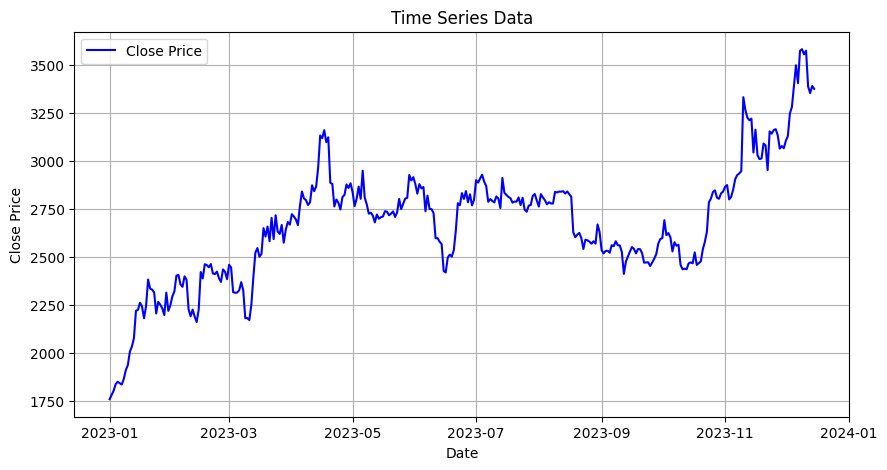

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Close'], linestyle='-', color='b', label='Close Price')
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

## Stationarity

We see ETH-AUD has a general upward trend over the year. To calculate reliable test statastics, we need stationarity in our data.

Stationarity is where a time series has a constant mean and constant variance over time. From a purely visual assessment, time plots that do not show trends or seasonality can be considered stationary.

### Transformations

We can transform the time series to be stationary by:
1. Taking the log;
2. Using the growth rate; or
3. Differencing over time (taking the log of today and minus it by the log of yesterday).

I'll start by taking the log:

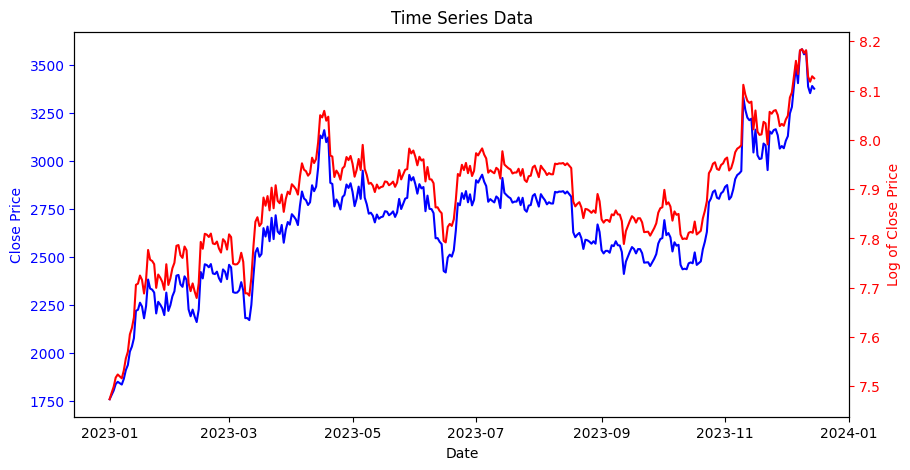

In [26]:
# Taking the log
import numpy as np

df['Log_Close'] = np.log(df['Close'])

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Close Price on the primary y-axis
ax1.plot(df.index, df['Close'], linestyle='-', color='b', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='b')
ax1.tick_params('y', colors='b')

# Create a secondary y-axis for Log of Close Price
ax2 = ax1.twinx()
ax2.plot(df.index, df['Log_Close'], linestyle='-', color='r', label='Log of Close Price')
ax2.set_ylabel('Log of Close Price', color='r')
ax2.tick_params('y', colors='r')

plt.title('Time Series Data')
plt.show()

Taking the log makes no difference (no pun intended) anyways but I'll still use it so I can interpret estimates as percentages.

Now I'll try the growth rate:

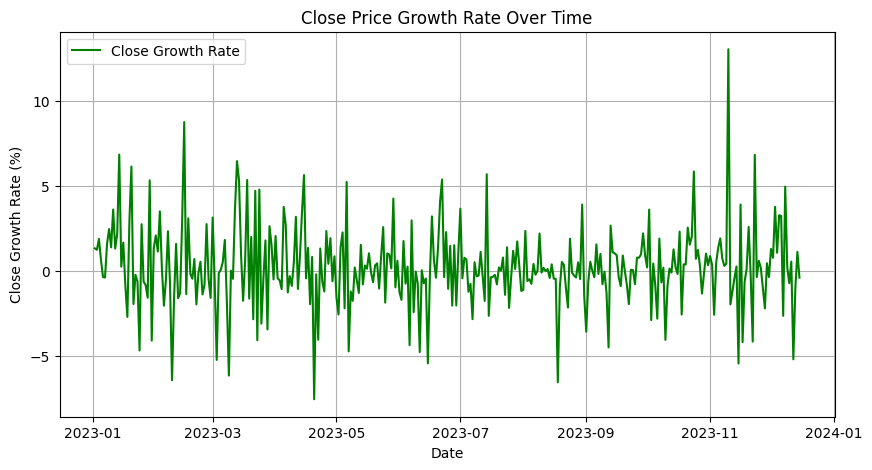

In [28]:
# Calculate the daily percentage change (growth rate)
df['Close_Growth_Rate'] = df['Close'].pct_change() * 100

# Plotting growth rate on its own
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Close_Growth_Rate'], linestyle='-', color='g', label='Close Growth Rate')
plt.title('Close Price Growth Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Close Growth Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

That looks like a legit stationary process.

### Testing for stationarity

We can test for stationarity by:
1. plotting the Auto-Correlation Function, and Partial Auto-Correlation Function (ACF and PACF respectively); or
2. using the Augmented Dickey-Fuller (ADF) test.

We first plot the ACF and PACF:

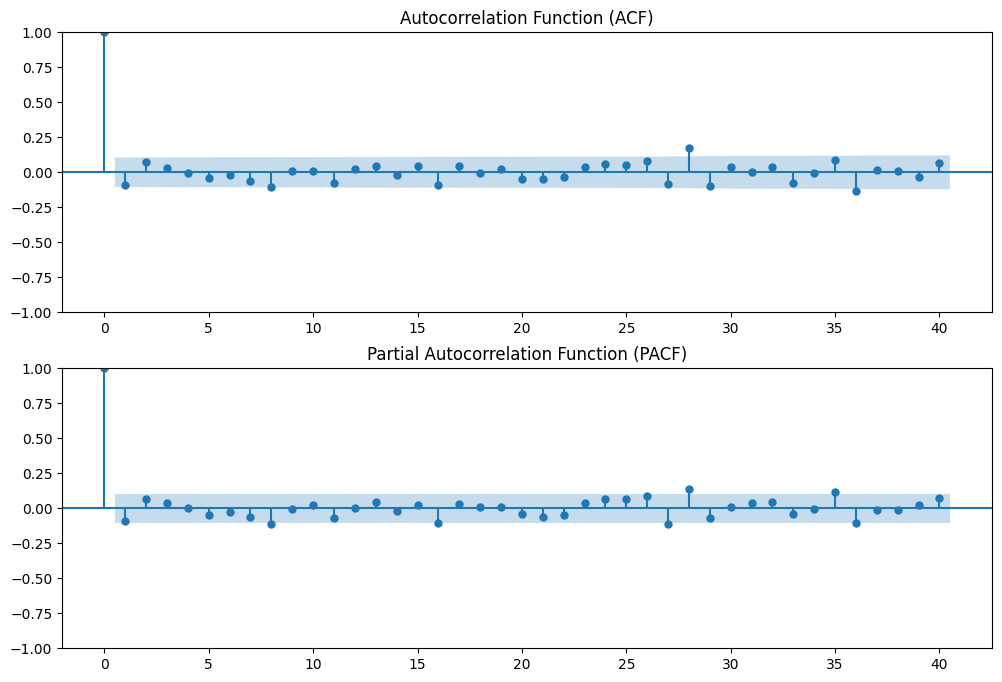

In [33]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate the daily percentage change (growth rate)
df['Close_Growth_Rate'] = df['Close'].pct_change() * 100
df = df.dropna()  # Drop the first row with NaN value

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(df['Close_Growth_Rate'], lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(df['Close_Growth_Rate'], lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

Both ACF and PACF seem truncated at the first lag. This indicates that there is no autocorrelation in the lags beyond the first lag.

We now test stationarity using the ADF test. If the p-value from the ADF test is below a certain significance level (commonly 0.05), you may reject the null hypothesis and conclude that the series is stationary.

In [34]:
import statsmodels.api as sm

# Calculate the daily percentage change (growth rate)
df['Close_Growth_Rate'] = df['Close'].pct_change() * 100
df = df.dropna()  # Drop the first row with NaN value

# Perform ADF test
result = sm.tsa.adfuller(df['Close_Growth_Rate'])

# Extract and print the results
adf_statistic = result[0]
p_value = result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

# Interpret the results
if p_value <= 0.05:
    print('Reject the null hypothesis. The series is likely stationary.')
else:
    print('Fail to reject the null hypothesis. The series may not be stationary.')


ADF Statistic: -20.184399136532484
p-value: 0.0
Reject the null hypothesis. The series is likely stationary.


Looks like its all stationary. 

## Modelling

We'll first try and fit an AR(1) model to the data given the ACF and PACF both truncating after the first lag.

In [35]:
import statsmodels.api as sm

# Assuming your DataFrame is named 'df'

# Calculate the daily percentage change (growth rate)
df['Close_Growth_Rate'] = df['Close'].pct_change() * 100
df = df.dropna()  # Drop the first row with NaN value

# Specify the lag order (p=1 for AR(1))
lag_order = 1

# Fit AR(1) model
model = sm.tsa.ARIMA(df['Close_Growth_Rate'], order=(lag_order, 0, 0))
results = model.fit()

# Print model summary
print(results.summary())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:      Close_Growth_Rate   No. Observations:                  343
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -784.803
Date:                Fri, 15 Dec 2023   AIC                           1575.606
Time:                        19:10:08   BIC                           1587.119
Sample:                    01-07-2023   HQIC                          1580.192
                         - 12-15-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2051      0.122      1.675      0.094      -0.035       0.445
ar.L1         -0.0887      0.055     -1.607      0.108      -0.197       0.020
sigma2         5.6871      0.276     20.621      0.0